# _*qGANs for Loading Random Distributions*_ 

### Introduction
Given $k$-dimensional data samples, we employ a quantum Generative Adversarial Network (qGAN) to learn the data's underlying random distribution and to load it directly into a quantum state:

$$ \big| g_{\theta}\rangle = \sum_{j=0}^{2^n-1} \sqrt{p_{\theta}^{j}}\big| j \rangle $$

where $p_{\theta}^{j}$ describe the occurrence probabilities of the basis states $\big| j\rangle$. 

The aim of the qGAN training is to generate a state $\big| g_{\theta}\rangle$ where $p_{\theta}^{j}$, for $j\in \left\{0, \ldots, {2^n-1} \right\}$, describe a probability distribution that is close to the distribution underlying the training data $X=\left\{x^0, \ldots, x^{k-1} \right\}$.

For further details please refer to <a href="https://arxiv.org/abs/1904.00043">Quantum Generative Adversarial Networks for Learning and Loading Random Distributions. Zoufal, Lucchi, Woerner. 2019.</a>

How to use a trained qGAN in an application, i.e., pricing of financial derivatives, is illustrated here:
<a href="../finance/machine_learning/qgan_option_pricing.ipynb">qGAN Option Pricing</a>.

In [10]:
import numpy as np
np.random.seed = 71

import matplotlib.pyplot as plt
%matplotlib inline

from qiskit import QuantumRegister, QuantumCircuit, BasicAer
from qiskit.circuit.library import TwoLocal, UniformDistribution

from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import QGAN
from qiskit.aqua.components.neural_networks import NumPyDiscriminator

### Load the Training Data
First, we need to load the $k$-dimensional training data samples (here k=1). <br/>
Next, the data resolution is set, i.e. the min/max data values and the number of qubits used to represent each data dimension.

In [11]:
# Number training data samples
N = 1000 

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
real_data = np.random.lognormal(mean=mu, sigma=sigma, size=N)

# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = np.array([0., 3.]) 
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [2]
k = len(num_qubits)

### Initialize the qGAN
The qGAN consists of a quantum generator $G_{\theta}$, a variational quantum circuit, and a classical discriminator $D_{\phi}$, a neural network. <br/>
To implement the quantum generator, we choose a depth-$1$ variational form that implements $R_Y$ rotations and $CZ$ gates which takes a uniform distribution as an input state. Notably, for $k>1$ the generator's parameters must be chosen carefully. For example, the circuit depth should be $>1$ because higher circuit depths enable the representation of more complex structures.<br/>
The classical discriminator is given by a $3$-layer neural network that applies linear transformations, leaky ReLU functions in the hidden layers and a sigmoid function in the output layer. Notably, the neural network is implemented with PyTorch. Please refer to https://pytorch.org/get-started/locally/ for PyTorch installation instructions.<br/>
Here, both networks are updated with the ADAM optimization algorithm.

In [12]:
# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 10
# Batch size
batch_size = 100

 # Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 1
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=BasicAer.get_backend('statevector_simulator'))

# Set entangler map
entangler_map = [[0, 1]]


# Set an initial state for the generator circuit
init_dist = UniformDistribution(sum(num_qubits))

# Set the ansatz circuit
var_form = TwoLocal(int(np.sum(num_qubits)), 'ry', 'cz', entanglement=entangler_map, reps=1)

# Set generator's initial parameters - In order to reduce the training time those parameters
init_params = [3., 1., 0.6, 1.6]

# You can increase the number of training epochs and use random initial parameters.
# init_params = np.random.rand(var_form.num_parameters_settable) * 2 * np.pi

# Set generator circuit by adding the initial distribution infront of the ansatz
g_circuit = var_form.compose(init_dist, front=True)

# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit)
# Set classical discriminator neural network
discriminator = NumPyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

### Run the qGAN Training
During the training the discriminator's and the generator's parameters are updated alternately w.r.t the following loss functions:
$$ L_G\left(\phi, \theta\right) = -\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log\left(D_{\phi}\left(g^{l}\right)\right)\right] $$
and
$$  L_D\left(\phi, \theta\right) =
	\frac{1}{m}\sum\limits_{l=1}^{m}\left[\log D_{\phi}\left(x^{l}\right) + \log\left(1-D_{\phi}\left(g^{l}\right)\right)\right], $$
with $m$ denoting the batch size and $g^l$ describing the data samples generated by the quantum generator.

Please note that the training will take a while ($\sim 20$ min).

In [13]:
# Run qGAN
result = qgan.run(quantum_instance)

In [14]:
print('Training results: ')
for key, value in result.items():
    print(key,'-', value)

Training results: 
params_d - [-0.26566188 -0.10138064  0.45154837 ... -0.02258372 -0.12509616
 -0.07139554]
params_g - [0.01847184 0.01748675 0.00210155 0.02712892]
loss_d - 0.693
loss_g - [0.6828]
rel_entr - 0.1862


### Training Progress & Outcome
Now, we plot the evolution of the generator's and the discriminator's loss functions during the training as well as the progress in the relative entropy between the trained and the target distribution.
<br/> Finally, we also compare the cumulative distribution function (CDF) of the trained distribution to the CDF of the target distribution.

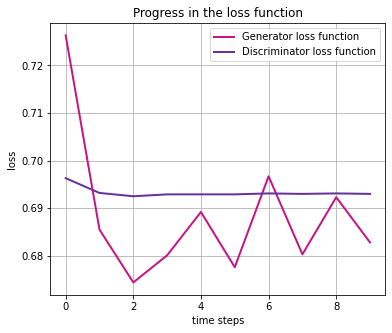

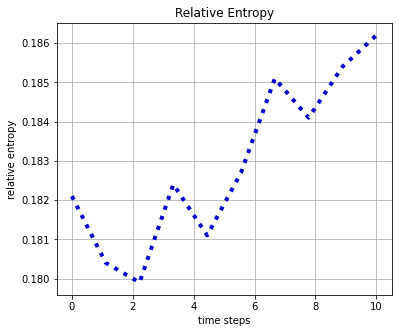

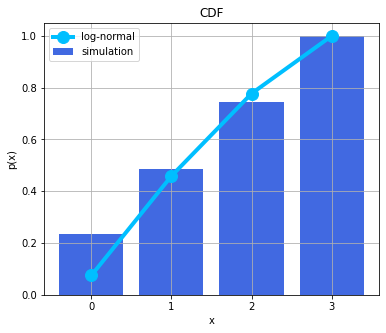

In [15]:
# Plot progress w.r.t the generator's and the discriminator's loss function
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label='Generator loss function', color='mediumvioletred', linewidth=2)
plt.plot(t_steps, qgan.d_loss, label='Discriminator loss function', color='rebeccapurple', linewidth=2)
plt.grid()
plt.legend(loc='best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()


# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title('Relative Entropy')
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

#Plot the PDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1] + 1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title('CDF')
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()

In [16]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright